In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data = pd.read_csv(
    "https://github.com/rjafari979/Information-Visualization-Data-Analytics-Dataset-/raw/refs/heads/main/Iris.csv"
)
print(data.columns)
data

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_scaler = LabelEncoder()
scaler = StandardScaler()

data["Species"] = label_scaler.fit_transform(data["Species"])
data[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]] = (
    scaler.fit_transform(
        data[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
    )
)
# drop the Id col
data = data.drop(columns=["Id"])
data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.900681,1.032057,-1.341272,-1.312977,0
1,-1.143017,-0.124958,-1.341272,-1.312977,0
2,-1.385353,0.337848,-1.398138,-1.312977,0
3,-1.506521,0.106445,-1.284407,-1.312977,0
4,-1.021849,1.263460,-1.341272,-1.312977,0
...,...,...,...,...,...
145,1.038005,-0.124958,0.819624,1.447956,2
146,0.553333,-1.281972,0.705893,0.922064,2
147,0.795669,-0.124958,0.819624,1.053537,2
148,0.432165,0.800654,0.933356,1.447956,2


In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = dataframe.drop(["Species"], axis=1).values
        self.targets = dataframe[["Species"]].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.long).squeeze()
        return x, y

In [6]:
split = int(0.8 * len(data))
# shuffle first
data = data.sample(frac=1).reset_index(drop=True)
train_rows = data[:split]
test_rows = data[split:]
len(train_rows), len(test_rows)

(120, 30)

In [7]:
train_data = CustomDataset(train_rows)
test_data = CustomDataset(test_rows)

len(train_data), len(test_data)

(120, 30)

In [8]:
train_data.targets.shape

(120, 1)

In [9]:
train_data.features[:4], train_data.targets[:4]

(array([[ 0.18982966, -0.35636057,  0.42156442,  0.39617188],
        [-1.02184904,  1.03205722, -1.227541  , -0.78708485],
        [-0.53717756,  0.80065426, -1.2844067 , -1.05003079],
        [ 2.24968346,  1.72626612,  1.67260991,  1.31648267]]),
 array([[1],
        [0],
        [0],
        [2]]))

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=2, shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([2, 4]), torch.Size([2]))

In [11]:
class CustomModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [12]:
model_0 = CustomModel(
    input_shape=4, hidden_units=2, output_shape=label_scaler.classes_.shape[0]
).to(device)

In [13]:
total_params = 0
for x in model_0.parameters():
    total_params += np.array(x.shape).prod()

total_params

19

In [14]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("../runs/iris")

In [15]:
# make example prediction


model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        y_preds = model_0(X)
        print(X.shape, y_preds.shape, y.shape)
    writer.add_graph(model_0, X)

writer.close()

torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])
torch.Size([2, 4]) torch.Size([2, 3]) torch.Size([2])


In [16]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
):
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        model.train()
        y_logits = model(X)
        y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y_true=y, y_pred=y_preds)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [17]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            y_logits = model(X)
            y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y_true=y, y_pred=y_preds)

            test_loss += loss.item()
            test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [18]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm


def train_model(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_score: callable,
    epochs: int = 3,
) -> dict[str, list[float]]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_score,
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_score,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

/home/noahpro/repos/pytorch-learn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.05)

model_0_train_results = train_model(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_score=accuracy_score,
    epochs=40,
)

100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


In [20]:
for epoch in range(len(model_0_train_results["train_loss"])):
    writer.add_scalars(
        "loss",
        {
            "train_loss": model_0_train_results["train_loss"][epoch],
            "test_loss": model_0_train_results["test_loss"][epoch],
        },
        epoch,
    )
    writer.add_scalars(
        "accuracy",
        {
            "train_acc": model_0_train_results["train_acc"][epoch],
            "test_acc": model_0_train_results["test_acc"][epoch],
        },
        epoch,
    )

writer.close()

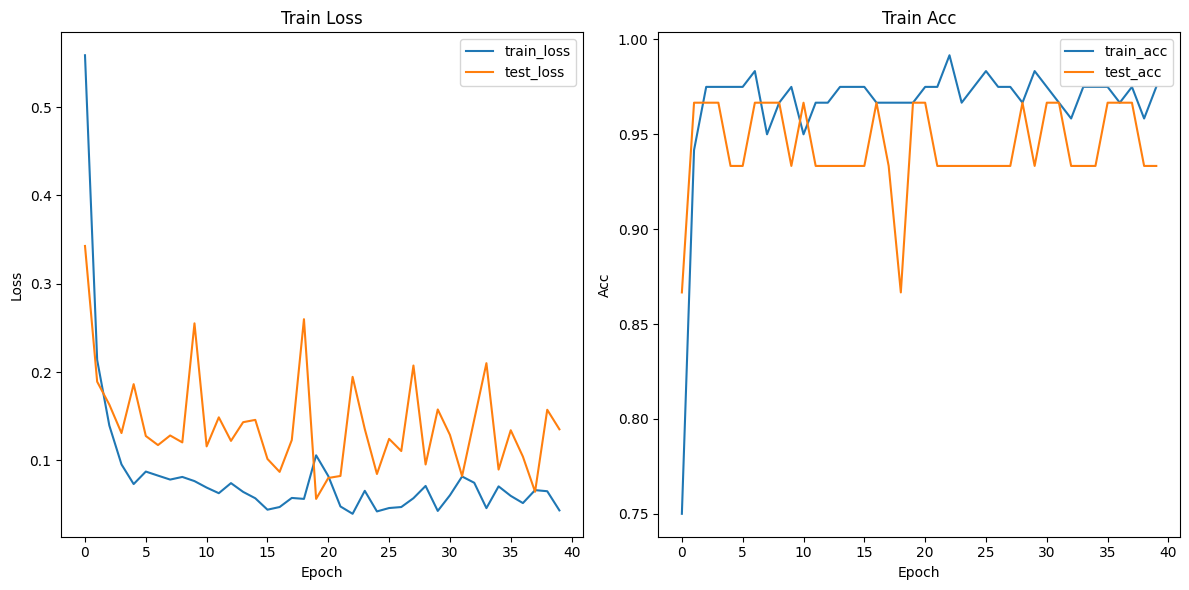

In [24]:
plt.figure(figsize=(12, 6))

# Plotting loss and accuracy
for i, metric in enumerate(["loss", "acc"]):
    plt.subplot(1, 2, i + 1)
    for key in model_0_train_results:
        if metric in key:
            plt.plot(
                range(len(model_0_train_results[key])),
                model_0_train_results[key],
                label=key,
            )
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"Train {metric.capitalize()}")
    plt.legend()

plt.tight_layout()
plt.show()